In [1]:
!pip install fairsearchcore tqdm

  Created wheel for fairsearchcore: filename=fairsearchcore-1.0.4-py3-none-any.whl size=10832 sha256=9f362df5ee62ca6c303c4ec21ec7f9fc1ba6b77f44a2f5c4822033969a4227e5
  Stored in directory: /root/.cache/pip/wheels/dd/d0/42/afb7cd10d9b0276f110d53cd68f7d93b7c91d672e668927804
Successfully built fairsearchcore


In [1]:
import numpy as np
from numpy.random import normal as norm
from matplotlib import pyplot as plt
import random
import fairsearchcore as fsc
from fairsearchcore.models import FairScoreDoc
from tqdm.notebook import tqdm

In [3]:
# fixed biases [d-color, d-shape]
# -0.5 => green are perceived of having higher quality
# 1.5 => stars are perceived of having lower quality
d = [-0.5, 1.5]

# there are equal number of stars and circles i.e. N
# out of which f * N are green circles and (1 - f) * N are orange circles
# out of which f * N are orange stars and (1 - f) * N are green stars
# [f, (1 - f)]
f = [0.2, 0.8]

In [4]:
# Genetare biased distribution
# real quality q0 is from N(0, 1)
# d - discrimination against 1s
# f - fraction of indviduals having property having hidden (second) property
# N - number of people

def generate(d = [0.5, 0.5], f = [0.5, 0.5], N = [2000, 2000]):
    # size of groups
    s = [(1 - f[0]) * N[0], f[0] * N[0], (1 - f[1]) * N[1], f[1] * N[1]]
    s = [int(x) for x in s]

    # vector of properties
    a = [(0,0)] * s[0] + [(0,1)] * s[1] + [(1,0)] * s[2] + [(1,1)] * s[3]

    m = 0
    st = 1
    q0 = norm(m, st, len(a))

    # creating bias
    bias = [0 for i in range(s[0])] + [-d[1] * st for i in range(s[1])] + [-d[0] * st for i in range(s[2])] + [-d[1] * st - d[0] * st for i in range(s[3])]
    q = q0 + bias

    # shuffling the results
    rnd = [x for x in range(len(a))]
    random.shuffle(rnd)

    q = [q[i] for i in rnd]
    a = [a[i] for i in rnd]    
    q0 = [q0[i] for i in rnd]

    # return vectors of properties, perceived qualities and real qualities
    return a, q, q0

In [5]:
# return individuals with top percieved qualities
def getTop(a, q, top = 0.1):    
    top = int(len(q) * top)
    ordered = [i for i in sorted(zip(q, a), reverse = True)]
    return ordered[:top]

# return individuals top individuals after debiasing
def getTopDebiasedRanked(a, q, top = 0.1):
    # Debiasing is always on the visible (first) attribute
    #     Allocate proportional quotas
    quota_1 = int(len([x for x in a if x[0] == 1]) * top)
    quota_0 = int(len([x for x in a if x[0] == 0]) * top)

    ordered = [i for i in sorted(zip(q, a), reverse = True)]

    return [x for x in ordered if x[1][0] == 0][:quota_0] + [x for x in ordered if x[1][0] == 1][:quota_1]
         
# return individuals top individuals after debiasing
def getTopDebiased(a, q, top = 0.1):
    quota_list = getTopDebiasedRanked(a, q, top)
    quota_1 = len([x for x in quota_list if x[1][0] == 1]) / len(quota_list)
    sorted_items = sorted(quota_list, reverse = True)
    ordered = [FairScoreDoc(index, item[0], item[1][0] == 1) for index, item in enumerate(sorted_items)]
    fair = fsc.Fair(len(quota_list), quota_1, 0.1)
    re_ranked = fair.re_rank(ordered)
    return [(item.score, (sorted_items[item.id][1])) for item in re_ranked]

# Compute chances to be in top k% for aggregated groups before and after debiasing
# d => fixed biases []
# f => number of elements
def get_aggregated(d, f, Nsim, k_range):
    results = {'original': {0: [], 1: []},
               'debiased': {0: [], 1: []}}


    # shapes(invisible) => 0: circle; 1: stars
    # colors(visible) => 0: orange; 1: green
    groups = [0, 1]

    for k in k_range:
        simulations = {'original': {0: [], 1: []},
                       'debiased': {0: [], 1: []}}

        for i in tqdm(range(0, Nsim), desc='Simulations for top {}'.format(k*100)):

            # properties, perceived qualities and real qualities
            a, q, q0 = generate(d, f, [200, 200])

            for group in groups:

                # compute expected chances to be in top
                exp = len([x for x in a if x[0] == group]) / len(q)

                for approach in ['original', 'debiased']:

                    if approach == 'original':
                       top = getTop(a, q, k)
                    else:
                       top = getTopDebiased(a, q, k)

                    # compute real chances to be in top
                    real = len([x for x in top if x[1][0] == group]) / len(top)

                    simulations[approach][group].append((real - exp) / exp)

        for group in [0, 1]:
            for approach in ['original', 'debiased']:
                results[approach][group].append(np.mean(simulations[approach][group]))
    return results

def plot_aggregated(results):
    colors = ['orange', 'green']
    styles = {'original': '-', 'debiased': '--'}

    for approach in ['original', 'debiased']:
        for group in [0, 1]:
            plt.plot(k_range, results[approach][group], color = colors[group], ls = styles[approach])

    plt.axhline(0, color='k', linestyle='dashed', linewidth=1)
    plt.xlabel('top k')
    plt.ylabel('representation bias')

In [6]:
# for quick results
Nsim = 5

# to fetch top k% candidates
k_range = [i / 100 for i in range(1, 101, 5)]

Simulations for top 1.0:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/fairsearchcore/fair.py:165: UserWarning: Library has not been tested with values outside this range
  warnings.warn("Library has not been tested with values outside this range")


Simulations for top 6.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 11.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 16.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 21.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 26.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 31.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 36.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 41.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 46.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 51.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 56.00000000000001:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 61.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 66.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 71.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 76.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 81.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 86.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 91.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 96.0:   0%|          | 0/5 [00:00<?, ?it/s]

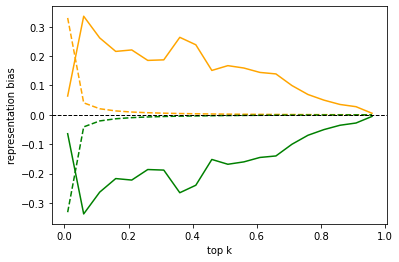

In [7]:
results_agg = get_aggregated(d, f, Nsim, k_range)
plot_aggregated(results_agg)

In [8]:
# Compute chances to be in top k% for disaggregated groups before and after debiasing
def get_disaggregated(d, f, Nsim, k_range):
    groups = [(0,0),(0,1),(1,0),(1,1)]
    
    results = {'original': {g:[] for g in groups},
               'debiased': {g:[] for g in groups}}

    for k in k_range:    
        simulations = {'original': {g:[] for g in groups},
                       'debiased': {g:[] for g in groups}}
        
        for i in tqdm(range(0, Nsim), desc='Simulations for top {}'.format(k*100)):
            a, q, q0 = generate(d, f, [200, 200])
            
            for g in groups:
                # compute expected chances to be in top
                exp = len([x for x in a if x == g]) / len(q)
                
                for approach in ['original', 'debiased']:
                    if approach == 'original':
                       top = getTop(a, q, k)
                    else:
                       top = getTopDebiased(a, q, k)
                    # compute real chances to be in top
                    real = len([x for x in top if x[1] == g]) / len(top)
                    simulations[approach][g].append((real - exp) / exp)

        for g in groups:
            for approach in ['original', 'debiased']:
                results[approach][g].append(np.mean(simulations[approach][g]))
    return results

def plot_disaggregated(results):
    groups = [(0,0),(0,1),(1,0),(1,1)]
    fill = {'original': 'full', 'debiased': 'none'}
    colors = ['orange', 'green']
    shapes = ['o', '*']
    for g in groups:
        for approach in ['original', 'debiased']:            
            plt.plot(k_range, results[approach][g], shapes[g[1]], color = colors[g[0]], lw = 2, fillstyle = fill[approach])

    plt.axhline(0, color='k', linestyle='dashed', linewidth=1)
    plt.fill_between(k_range, results['debiased'][(0,1)], results['original'][(0,1)], color='orange', alpha=.25)
            
    plt.xlabel('top k')
    plt.ylabel('representation bias')

Simulations for top 1.0:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/fairsearchcore/fair.py:165: UserWarning: Library has not been tested with values outside this range
  warnings.warn("Library has not been tested with values outside this range")


Simulations for top 6.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 11.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 16.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 21.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 26.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 31.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 36.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 41.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 46.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 51.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 56.00000000000001:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 61.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 66.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 71.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 76.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 81.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 86.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 91.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 96.0:   0%|          | 0/5 [00:00<?, ?it/s]

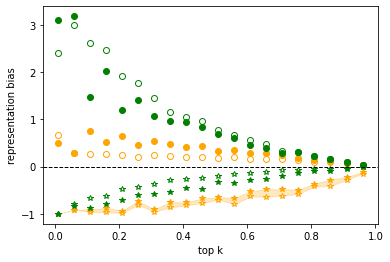

In [9]:
results_diss = get_disaggregated(d, f, Nsim, k_range)
plot_disaggregated(results_diss)

In [10]:
np.save('results_fair_synth.npy', {'agg': results_agg, 'diss_agg': results_diss})

In [2]:
read_dictionary = np.load('results_fair_synth.npy', allow_pickle='TRUE').item()
read_dictionary

{'agg': {'original': {0: [0.064,
    0.33578260869565224,
    0.2619534883720931,
    0.2160000000000001,
    0.22103614457831328,
    0.18537864077669908,
    0.18726829268292694,
    0.263965034965035,
    0.23861349693251546,
    0.15121311475409838,
    0.1675172413793104,
    0.1594260089686099,
    0.1444567901234568,
    0.13934980988593162,
    0.09971731448763256,
    0.06926732673267333,
    0.050000000000000044,
    0.03530612244897964,
    0.027727272727272757,
    0.005313315926892957],
   1: [-0.06432160804020101,
    -0.3374699584880926,
    -0.2632698375598924,
    -0.2170854271356784,
    -0.22214687897317908,
    -0.18631019173537589,
    -0.18820933937982587,
    -0.26529149242717076,
    -0.2398125597311712,
    -0.1519729796523601,
    -0.1683590365621209,
    -0.1602271446920702,
    -0.14518270364166508,
    -0.14005006018686586,
    -0.10021840652023366,
    -0.06961540375143035,
    -0.05025125628140701,
    -0.03548354014972815,
    -0.02786660575605293,
    -